In [1]:
from Environment.snake_game import SnakeGame
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import imageio # For video generation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random

GAME_WIDTH = 20
GAME_HEIGHT = 20
FOOD_AMOUNT = 1
GRASS_GROWTH = 0.001
MAX_GRASS = 0.05
BORDER_SIZE = 1 # Add a visual border of 1 pixel
MAX_GAME_STEPS = 500 # Set a limit for the game length
VIDEO_FILENAME = "snake_ai_player.gif"
FPS = 5 # Faster for smoother video

TEMPERATURE_END = 0.1
TEMPERATURE_START = 2.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
"""
    Heuristic Player
"""
class SnakeHeuristic:
    def __init__(self, game: SnakeGame):
        self.game = game
        # Map: game_direction_idx -> (row_change, col_change)
        self.delta_coords = {
            0: (-1, 0),  # Up
            1: (0, 1),   # Right
            2: (1, 0),   # Down
            3: (0, -1)   # Left
        }

    def _get_closest_apple_pos(self):
        if not self.game.apples:
            return None
        
        head_r, head_c = self.game.snake[0]
        closest_apple = None
        min_dist = float('inf')

        for apple_r, apple_c in self.game.apples:
            dist = abs(apple_r - head_r) + abs(apple_c - head_c)
            if dist < min_dist:
                min_dist = dist
                closest_apple = (apple_r, apple_c)
        return closest_apple

    def _is_safe_move(self, next_head_r, next_head_c):
        if not (0 <= next_head_r < self.game.height and \
                0 <= next_head_c < self.game.width):
            return False

        if (next_head_r, next_head_c) in self.game.snake[1:]:
            return False
            
        return True

    def choose_action(self):
        target_apple_pos = self._get_closest_apple_pos()

        if target_apple_pos is None:
            return 0

        head_r, head_c = self.game.snake[0]
        current_game_direction = self.game.direction

        candidate_actions = []

        for action_value in [-1, 0, 1]:
            next_game_direction = (current_game_direction + action_value) % 4
            if next_game_direction < 0: next_game_direction += 4

            dr, dc = self.delta_coords[next_game_direction]

            next_head_r, next_head_c = head_r + dr, head_c + dc

            if self._is_safe_move(next_head_r, next_head_c):
                dist_to_apple = abs(target_apple_pos[0] - next_head_r) + \
                                abs(target_apple_pos[1] - next_head_c)
                candidate_actions.append({
                    'action': action_value, 
                    'distance': dist_to_apple
                })
        
        if not candidate_actions:
            return 0

        def sort_key(candidate):
            action = candidate['action']
            preference = 0
            if action == 1: preference = 1
            elif action == -1: preference = 2
            return (candidate['distance'], preference)

        candidate_actions.sort(key=sort_key)
        
        return candidate_actions[0]['action']

    def play_game_and_record(self, max_steps: int, video_filename: str = "snake_heuristic_game.gif", fps: int = 5):
        frames = []
        history = {
            'board': [],
            'reward': [],
            'done': -1,
            'info': []
        }
        board_state, reward, done, info = self.game.reset()
        
        frames.append((board_state * 255).astype(np.uint8))

        print(f"Starting game with heuristic. Max steps: {max_steps}. Recording to {video_filename}")

        for step_num in range(max_steps):
            history['board'].append(board_state)
            history['reward'].append(reward)
            history['info'].append(info)
            if done:
                history['done'] = step_num
                print(f"Game ended prematurely at step {step_num} before taking action. Score: {info['score']}")
                break

            action_to_take = self.choose_action()
            board_state, reward, done, info = self.game.step(action_to_take)
            
            frames.append((board_state * 255).astype(np.uint8))
            
            if (step_num + 1) % 100 == 0:
                 print(f"Step {step_num+1}/{max_steps}, Score: {info['score']}, Done: {done}")


            """if done:
                print(f"Game over at step {step_num+1}. Final Score: {info['score']}")
                break"""
        else:
            print(f"Game finished after {max_steps} steps (max_steps reached). Final Score: {self.game.score}")

        if frames:
            print(f"Saving video with {len(frames)} frames at {fps} FPS...")
            try:
                imageio.mimsave(video_filename, frames, fps=fps)
                print(f"Video saved successfully as {video_filename}")
            except Exception as e:
                print(f"Error saving video: {e}")
                print("Please ensure you have an imageio backend installed (e.g., 'pip install imageio[ffmpeg]' for MP4 or 'pip install imageio pillow' for GIF).")
        else:
            print("No frames recorded.")

        return history

In [3]:
def boltzmann_action(q_values, temperature):
    probabilities = F.softmax(q_values / temperature, dim=1)
    return torch.multinomial(probabilities, 1).item()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import collections

"""
    DQN, Replay Buffer, and Helper Functions
"""
class SnakeDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(SnakeDQN, self).__init__()
        C, H, W = input_shape
        
        self.conv = nn.Sequential(
            nn.Conv2d(C, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        dummy_input = torch.zeros(1, *input_shape)
        conv_out_size = self.conv(dummy_input).view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
def plot_training_metrics(scores, losses, q_values, fig_name=None):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 12))  # Adjusted for vertical layout

    plt.subplot(3, 1, 1)
    plt.plot(scores)
    plt.title("Scores")
    plt.xlabel("Episode")
    plt.ylabel("Score")

    plt.subplot(3, 1, 2)
    plt.plot(losses)
    plt.title("Average Loss per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Loss")

    plt.subplot(3, 1, 3)
    plt.plot(q_values)
    plt.title("Average Q-value per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Q-value")

    plt.tight_layout()
    if fig_name:
        plt.savefig(fig_name)
    plt.show()

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, min(batch_size, len(self.buffer)))
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (
            torch.tensor(np.array(states), dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(np.array(next_states), dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)
        )

    def __len__(self):
        return len(self.buffer)
    
class PrioritizedReplayBuffer:
    def __init__(self, capacity=10000, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha

    def add(self, state, action, reward, next_state, done, td_error=None):
        # Priority = abs(td_error) or max priority if td_error is None
        max_priority = self.priorities.max() if self.buffer else 1.0
        priority = abs(td_error) + 1e-5 if td_error is not None else max_priority

        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        self.priorities[self.pos] = priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            probs = self.priorities
        else:
            probs = self.priorities[:len(self.buffer)]

        probs = probs ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        states, actions, rewards, next_states, dones = zip(*samples)

        return (
            torch.tensor(np.array(states), dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(np.array(next_states), dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(weights, dtype=torch.float32).unsqueeze(1).to(device),
            indices
        )

    def update_priorities(self, indices, td_errors):
        for idx, error in zip(indices, td_errors):
            self.priorities[idx] = abs(error) + 1e-5

    def __len__(self):
        return len(self.buffer)

In [67]:
def train_adv_dqn(env, model, decay_pattern, using_heuristic=False, heuristic=None, input_shape=None, n_actions=None, bufferType="BasicReplay", exploration_style = "epsilon"):
    target_model = type(model)(input_shape, n_actions).to(device)
    target_model.load_state_dict(model.state_dict())
    target_model.eval()

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    epsilon_max = 0.001
    epsilon_min = 0.001
    epsilon_decay = 0.990
    buffer = ReplayBuffer(capacity=10000) if bufferType == "BasicReplay" else PrioritizedReplayBuffer(capacity=10000)
    #buffer = PrioritizedReplayBuffer(capacity=10000)
    scores = []
    avg_scores = []
    losses = []
    q_values = []
    epsilons = []

    max_train_episodes = 1000
    update_target_every = 100
    batch_size = 32
    gamma = 0.99
    beta_frames = 100000
    global_step = 0
    epsilon = epsilon_max
    decay_per_step = 0.05
    epsilon_decay_rate = 0.99
    MAX_STEPS = max_train_episodes * MAX_GAME_STEPS


    is_prioritized = isinstance(buffer, PrioritizedReplayBuffer)
    print(f"we are using {bufferType} buffer")

    # WARMUP
    if using_heuristic and heuristic is not None:
        print("Starting warmup with heuristic for 50 episodes...")
        for _ in range(50):
            state, _, done, _ = env.reset()
            state = np.transpose(state, (2, 0, 1))
            
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            done = False
            steps = 0
            while not done and steps < MAX_GAME_STEPS:
                action = heuristic.choose_action()

                next_state, reward, done, info = env.step(action)
                next_state_proc = np.transpose(next_state, (2, 0, 1))

                buffer.add(state.cpu().squeeze(0).numpy(), [-1, 0, 1].index(action), reward, next_state_proc, float(done))

                state = torch.tensor(next_state_proc, dtype=torch.float32).unsqueeze(0).to(device)
                steps += 1

        print(f"Warmup finished. Replay buffer size: {len(buffer)}")

    for episode in range(1, max_train_episodes + 1):
        state, _, done, _ = env.reset()
        state = np.transpose(state, (2, 0, 1))
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        total_loss = 0
        total_q = 0
        steps = 0
        done = False

        while not done and steps < MAX_GAME_STEPS:
            if random.random() < epsilon:
                action = random.choice([-1, 0, 1])
            else:
                with torch.no_grad():
                    q_vals = model(state)
                    action_idx = q_vals.argmax().item()
                    action = [-1, 0, 1][action_idx]

            next_state, reward, done, info = env.step(action)
            next_state_proc = np.transpose(next_state, (2, 0, 1))
            next_state_tensor = torch.tensor(next_state_proc, dtype=torch.float32).unsqueeze(0).to(device)

            if is_prioritized:
                with torch.no_grad():
                    q_val = model(state).gather(1, torch.tensor([[[-1, 0, 1].index(action)]]).to(device))
                    next_q = target_model(next_state_tensor).max(1)[0].unsqueeze(1)
                    td_error = reward + gamma * (1 - float(done)) * next_q - q_val
                    td_error = td_error.item()

                buffer.add(
                    state.cpu().squeeze(0).numpy(),
                    [-1, 0, 1].index(action),
                    reward,
                    next_state_proc,
                    float(done),
                    td_error=td_error
                )
            else:
                buffer.add(
                    state.cpu().squeeze(0).numpy(),  
                    [-1, 0, 1].index(action),
                    reward,
                    next_state_proc,
                    float(done)
                )

            state = next_state_tensor
            steps += 1
            global_step += 1

            # Learn from replay buffer
            if len(buffer) >= batch_size:
                if is_prioritized:
                    b_states, b_actions, b_rewards, b_next_states, b_dones, weights, indices = buffer.sample(batch_size)
                else:
                    b_states, b_actions, b_rewards, b_next_states, b_dones = buffer.sample(batch_size)

                q_values_pred = model(b_states).gather(1, b_actions)
                with torch.no_grad():
                    next_qs = target_model(b_next_states)
                    max_next_qs = next_qs.max(1, keepdim=True)[0]
                    q_target = b_rewards + gamma * (1 - b_dones) * max_next_qs

                td_errors = q_target - q_values_pred
                if is_prioritized:
                    loss = (td_errors.pow(2) * weights).mean()
                else:
                    loss = nn.MSELoss()(q_values_pred, q_target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if isinstance(buffer, PrioritizedReplayBuffer):
                    buffer.update_priorities(indices, td_errors.detach().cpu().numpy().squeeze())

                total_loss += loss.item()
                total_q += q_values_pred.mean().item()

            # Target network update
            if global_step % update_target_every == 0:
                target_model.load_state_dict(model.state_dict())

        # Decay epsilon after each episode
        #if epsilon > epsilon_min:
         #   epsilon *= epsilon_decay

        epsilons.append(epsilon)
        if exploration_style == "boltzmann":
            temperature = max(TEMPERATURE_END, TEMPERATURE_START * np.exp(-temperature_decay_rate * total_steps))
        elif exploration_style == "epsilon":
            if decay_pattern == "linear":
                #epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
                epsilon = max(epsilon_min, epsilon_max - (3 * epsilon_max * episode / max_train_episodes)) # 3x so its faster decaying
            elif decay_pattern == "exponential":
                epsilon = max(epsilon_min, epsilon * epsilon_decay_rate)
            elif decay_pattern == "step":
                if episode % 10 == 0:
                    epsilon = max(epsilon_min, epsilon - decay_per_step)
        else:
            print("Wrong decay pattern")
            
        scores.append(info['score'])
        losses.append(total_loss / steps if steps > 0 else 0)
        q_values.append(total_q / steps if steps > 0 else 0)

        if episode % 10 == 0:
            print(f"Episode {episode} | Score: {info['score']} | Loss: {losses[-1]:.4f} | Q: {q_values[-1]:.4f}")

        if episode % 50 == 0:
            avg_score = sum(scores[-50:]) / 50
            avg_scores.append(avg_score)
            print(f"Episode {episode}, Avg Score: {avg_score:.2f}, Epsilon: {epsilon:.3f}")

    return model, avg_scores, losses, q_values, epsilons

In [68]:
import time

In [69]:
game_instance = SnakeGame(
    width=GAME_WIDTH, 
    height=GAME_HEIGHT, 
    food_amount=FOOD_AMOUNT, 
    border=BORDER_SIZE, 
    grass_growth=GRASS_GROWTH, 
    max_grass=MAX_GRASS)
state = game_instance.reset()[0]
state = np.transpose(state, (2, 0, 1))
state_shape = state.shape
model = SnakeDQN(state_shape, n_actions=3).to(device)

heuristic = SnakeHeuristic(game_instance)

start_time = time.time()
trained_model, avg_scores, losses, q_values, epsilons = train_adv_dqn(
    game_instance, 
    model,
    decay_pattern="linear",
    using_heuristic=True, 
    heuristic=heuristic,
    input_shape=state_shape, 
    n_actions=3
)
end_time = time.time()
print("Training time: ", end_time-start_time)

we are using BasicReplay buffer
Starting warmup with heuristic for 50 episodes...
Warmup finished. Replay buffer size: 10000
Episode 10 | Score: 0.1 | Loss: 0.1094 | Q: 0.1942
Episode 20 | Score: 0.6 | Loss: 0.0701 | Q: 0.3494
Episode 30 | Score: 0.3 | Loss: 0.0700 | Q: 0.4720
Episode 40 | Score: 0.7500000000000001 | Loss: 0.0722 | Q: 0.5482
Episode 50 | Score: 0.1 | Loss: 0.0428 | Q: 0.6848
Episode 50, Avg Score: 0.39, Epsilon: 0.001
Episode 60 | Score: 0.7000000000000001 | Loss: 0.0777 | Q: 0.7462
Episode 70 | Score: 0.39999999999999997 | Loss: 0.1225 | Q: 0.9226
Episode 80 | Score: 0.1 | Loss: 0.1335 | Q: 0.9102
Episode 90 | Score: 0.7500000000000001 | Loss: 0.0995 | Q: 1.0611
Episode 100 | Score: 0.1 | Loss: 0.1502 | Q: 1.1249
Episode 100, Avg Score: 0.41, Epsilon: 0.001
Episode 110 | Score: 0.5499999999999999 | Loss: 0.1151 | Q: 1.3163
Episode 120 | Score: 0.3 | Loss: 0.1204 | Q: 1.4050
Episode 130 | Score: 0.15000000000000002 | Loss: 0.1799 | Q: 1.4864
Episode 140 | Score: 0.3 | 

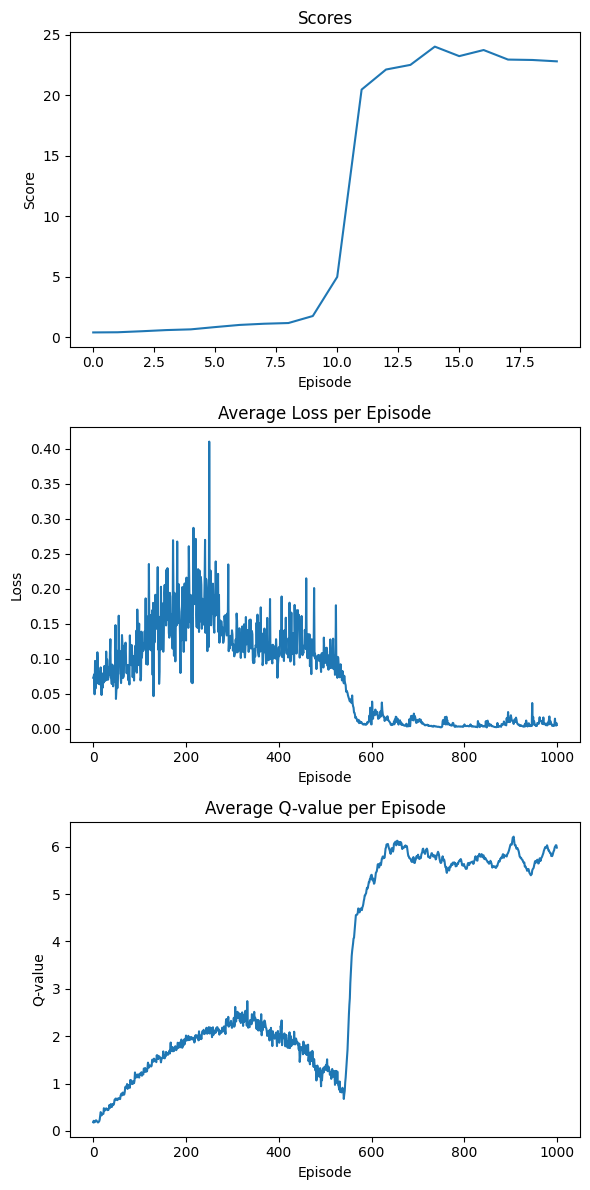

In [70]:
plot_training_metrics(avg_scores, losses, q_values)

In [63]:
game_instance = SnakeGame(
    width=GAME_WIDTH, 
    height=GAME_HEIGHT, 
    food_amount=FOOD_AMOUNT, 
    border=BORDER_SIZE, 
    grass_growth=GRASS_GROWTH, 
    max_grass=MAX_GRASS)
state = game_instance.reset()[0]
state = np.transpose(state, (2, 0, 1))
state_shape = state.shape
model = SnakeDQN(state_shape, n_actions=3).to(device)

heuristic = SnakeHeuristic(game_instance)

start_time = time.time()
trained_model2, avg_scores2, losses2, q_values2, epsilons2 = train_adv_dqn(
    game_instance, 
    model,
    decay_pattern="exponential",
    using_heuristic=True, 
    heuristic=heuristic,
    input_shape=state_shape, 
    n_actions=3
)
end_time = time.time()
print("Training time: ", end_time-start_time)

we are using BasicReplay buffer
Starting warmup with heuristic for 50 episodes...
Warmup finished. Replay buffer size: 10000
Episode 10 | Score: 1.5000000000000007 | Loss: 0.0666 | Q: 0.2719
Episode 20 | Score: 0.9500000000000003 | Loss: 0.0687 | Q: 0.5446
Episode 30 | Score: 1.6560000000000008 | Loss: 0.0794 | Q: 0.8095
Episode 40 | Score: 0.44999999999999996 | Loss: 0.1022 | Q: 0.9442
Episode 50 | Score: 2.1500000000000004 | Loss: 0.1117 | Q: 1.0535
Episode 50, Avg Score: 0.90, Epsilon: 0.605
Episode 60 | Score: 0.7000000000000001 | Loss: 0.1128 | Q: 1.2760
Episode 70 | Score: 0.7000000000000001 | Loss: 0.1167 | Q: 1.4818
Episode 80 | Score: 0.5499999999999999 | Loss: 0.1537 | Q: 1.8493
Episode 90 | Score: 0.25 | Loss: 0.1385 | Q: 2.0404
Episode 100 | Score: 0.35 | Loss: 0.1432 | Q: 2.2296
Episode 100, Avg Score: 1.09, Epsilon: 0.366
Episode 110 | Score: 0.8000000000000002 | Loss: 0.1528 | Q: 2.3946
Episode 120 | Score: 0.6 | Loss: 0.1755 | Q: 2.5055
Episode 130 | Score: 1.0500000000

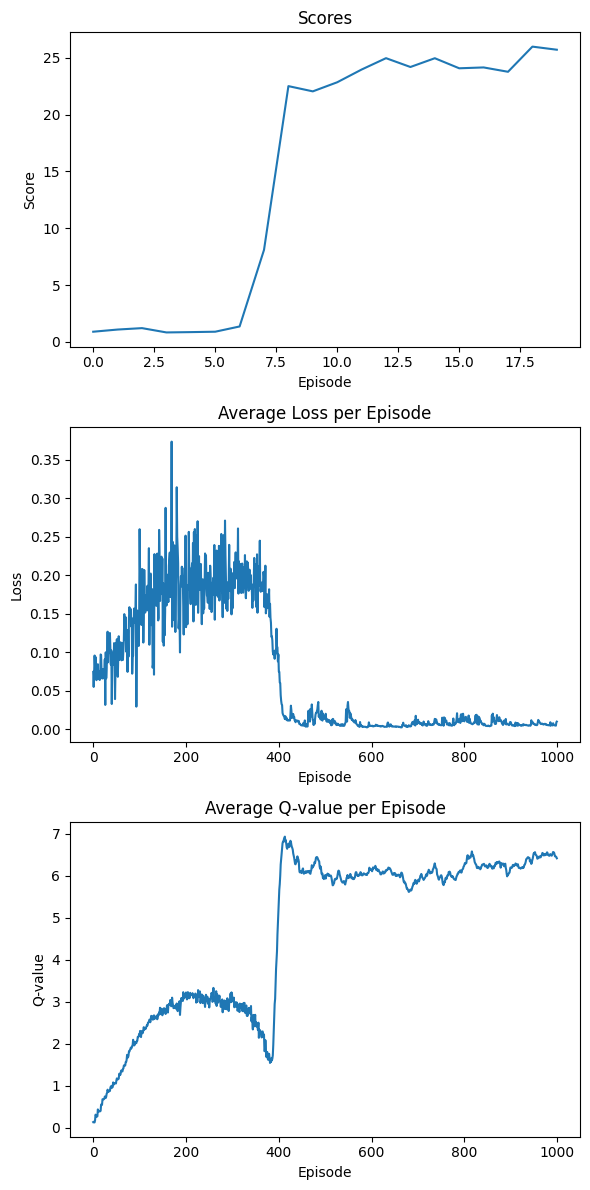

In [64]:
plot_training_metrics(avg_scores2, losses2, q_values2, "exponential_epsilon_task3.png")

In [65]:
game_instance = SnakeGame(
    width=GAME_WIDTH, 
    height=GAME_HEIGHT, 
    food_amount=FOOD_AMOUNT, 
    border=BORDER_SIZE, 
    grass_growth=GRASS_GROWTH, 
    max_grass=MAX_GRASS)
state = game_instance.reset()[0]
state = np.transpose(state, (2, 0, 1))
state_shape = state.shape
model = SnakeDQN(state_shape, n_actions=3).to(device)

heuristic = SnakeHeuristic(game_instance)

start_time = time.time()
trained_model3, avg_scores3, losses3, q_values3, epsilons3 = train_adv_dqn(
    game_instance, 
    model,
    decay_pattern="step",
    using_heuristic=True, 
    heuristic=heuristic,
    input_shape=state_shape, 
    n_actions=3
)
end_time = time.time()
print("Training time: ", end_time-start_time)

we are using BasicReplay buffer
Starting warmup with heuristic for 50 episodes...
Warmup finished. Replay buffer size: 10000
Episode 10 | Score: 0.15000000000000002 | Loss: 0.1026 | Q: 0.2463
Episode 20 | Score: 0.3 | Loss: 0.0710 | Q: 0.6231
Episode 30 | Score: 0.6140000000000001 | Loss: 0.0721 | Q: 0.7102
Episode 40 | Score: 0.15000000000000002 | Loss: 0.0733 | Q: 0.9811
Episode 50 | Score: 0.7000000000000001 | Loss: 0.0961 | Q: 1.2299
Episode 50, Avg Score: 0.87, Epsilon: 0.750
Episode 60 | Score: 0.8000000000000002 | Loss: 0.1212 | Q: 1.4669
Episode 70 | Score: 1.776000000000001 | Loss: 0.1103 | Q: 1.6700
Episode 80 | Score: 1.3120000000000005 | Loss: 0.1221 | Q: 1.8570
Episode 90 | Score: 1.5500000000000007 | Loss: 0.1513 | Q: 2.0498
Episode 100 | Score: 1.6500000000000008 | Loss: 0.1762 | Q: 2.2685
Episode 100, Avg Score: 0.94, Epsilon: 0.500
Episode 110 | Score: 0.8000000000000002 | Loss: 0.1024 | Q: 2.4056
Episode 120 | Score: 0.9000000000000002 | Loss: 0.2327 | Q: 2.4845
Episo

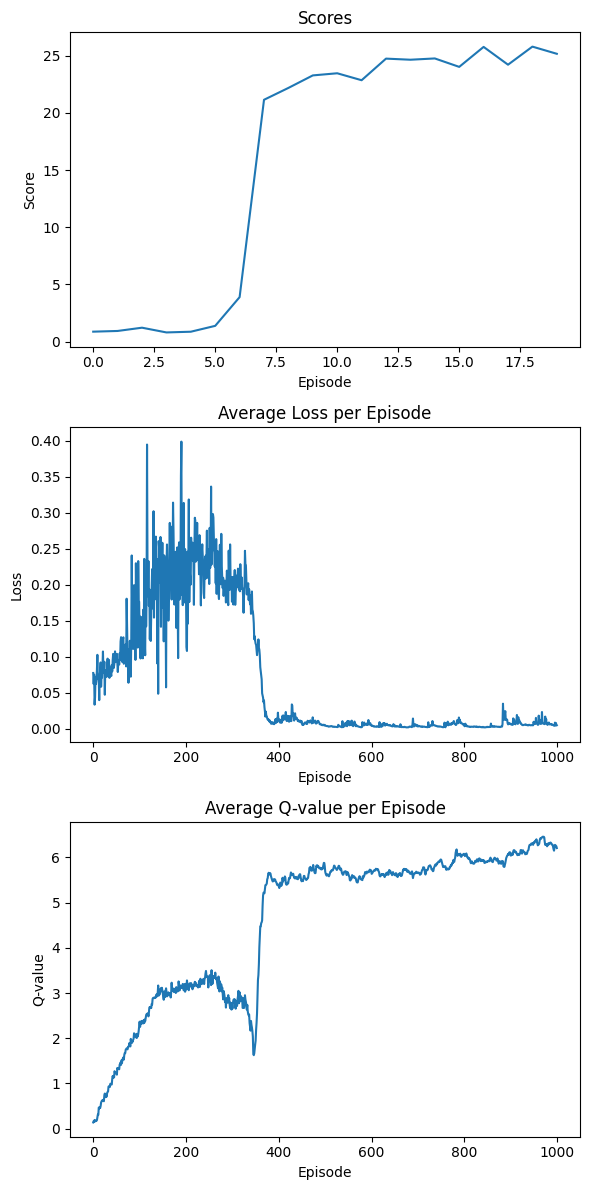

In [66]:
plot_training_metrics(avg_scores3, losses3, q_values3, "step_epsilon_task3.png")

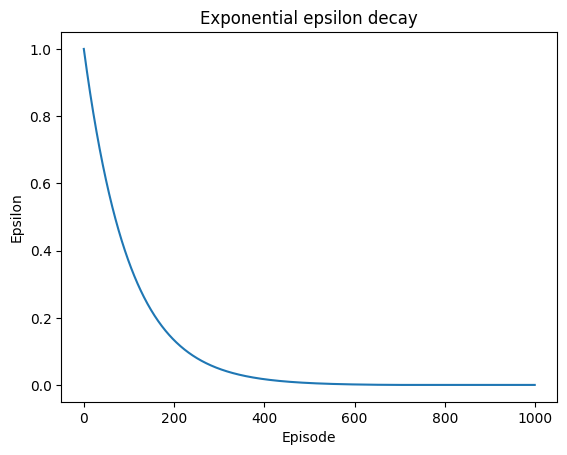

In [59]:
plt.plot(epsilons2)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Exponential epsilon decay")
plt.savefig("exponential_epsilon.png")
plt.show()